In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

### Database setup via SQLAlchemy

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Past 12 months of preciptation data 

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_12mo = pd.read_sql_query("SELECT date, prcp FROM measurement WHERE date between '2016-08-23' and '2017-08-23'", engine)

Text(0.5, 1.0, "Hawai'i precipitation: 8/23/2016 - 8/23/2017")

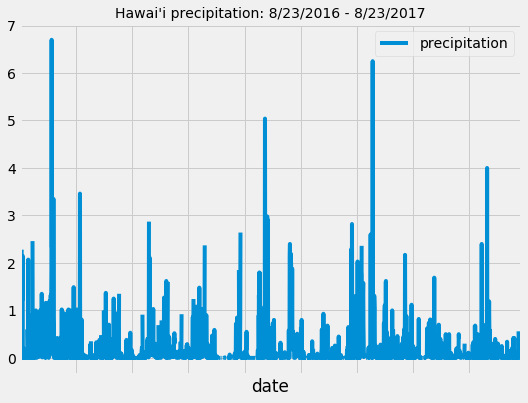

In [11]:
rain_12mo.set_index(keys='date', inplace=True)

# Sort the dataframe by date
rain_12mo.sort_index(inplace=True, ascending=True)

rain_12mo.rename(columns={'prcp': 'precipitation'}, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
rain_12mo.plot(y='precipitation', kind='line', figsize=(8,6))
plt.tick_params(labelbottom=False)   
plt.title('Hawai\'i precipitation: 8/23/2016 - 8/23/2017', fontsize=14)

### Precipitation summary

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_12mo_summary = rain_12mo.describe()
rain_12mo_summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station analysis
### Total number of stations

In [13]:
# Design a query to show how many stations are available in this dataset
station_count = engine.execute("SELECT count(id) as station_count FROM station")
for row in station_count: print(f'There are {row[0]} weather stations in this dataset.')

There are 9 weather stations in this dataset.


### Most active stations

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = engine.execute("SELECT s.station, count(m.id) as m_count FROM measurement m INNER JOIN station s on m.station = s.station GROUP BY s.station ORDER BY m_count DESC")
for row in active_stations: print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_temps = pd.read_sql_query("SELECT min(m.tobs) as min_temp, max(m.tobs) as max_temp, round(avg(m.tobs),1) as avg_temp \
                                 FROM measurement m \
                                 JOIN station s \
                                 ON m.station = s.station \
                                 WHERE s.station = 'USC00519281'", engine)
most_active_temps

,min_temp,max_temp,avg_temp
0,54.0,85.0,71.7


### Plotting 1y temperature data for most active station

Text(0.5, 0, 'Observed Temperature (F)')

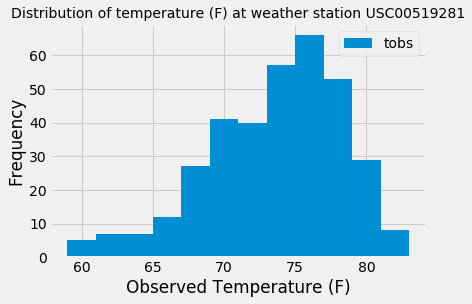

In [16]:
# Choose the station with the highest number of temperature observations.

temp_data = pd.read_sql_query("SELECT m.tobs, m.date, s.station \
                                 FROM measurement m \
                                 JOIN station s \
                                 ON m.station = s.station", engine)
t = temp_data.dropna().groupby('station')['tobs'].count()

t_most = t[t == max(t)] # USC00519281 is the measurement station with highest number of temp observations

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
t_most_temp_data = pd.read_sql_query("SELECT m.tobs, m.date, s.station \
                                 FROM measurement m \
                                 JOIN station s \
                                 ON m.station = s.station \
                                 WHERE m.date BETWEEN '2016-08-23' and '2017-08-23' \
                                 AND s.station = 'USC00519281'", engine)
t_most_temp_data.plot(y='tobs', kind='hist', bins=12)
plt.title("Distribution of temperature (F) at weather station USC00519281", fontsize=14)
plt.xlabel("Observed Temperature (F)")

## Bonus

## Temperature Analysis I

In [17]:
import datetime as dt
from scipy import mean
import scipy.stats as stats

In [18]:
'''
Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, 
for example, June and December?

Identify the average temperature in June at all stations across all available years in the dataset. 
Do the same for December temperature.

Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
Will you use a paired t-test, or an unpaired t-test? Why?
'''
june = '06'
dec = '12'

june_avg = session.query(func.avg(Measurement.tobs)).\
            filter(func.strftime("%m", Measurement.date) == june).\
            group_by(Measurement.station).all()
dec_avg = session.query(func.avg(Measurement.tobs)).\
            filter(func.strftime("%m", Measurement.date) == dec).\
            group_by(Measurement.station).all()

# Choosing the paired t-test because it's looking at the same subjects at different times https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html
stats.ttest_rel(june_avg, dec_avg)

# There is a statistically signficant difference between the two samples.
print(mean(june_avg), mean(dec_avg))

# It is (only) a few degrees cooler in December

74.85351018249018 71.21907046377945


## Temperature Analysis II
Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching 
dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

Plot the min, avg, and max temperature from your previous query as a bar chart.

Use the average temperature as the bar height.

Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [20]:
# Use `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.
past_year_temps = calc_temps('2016-08-23','2017-08-23')
print(past_year_temps)

[(58.0, 74.59058295964125, 87.0)]


Text(0.5, 1.0, 'Trip Avg Temp')

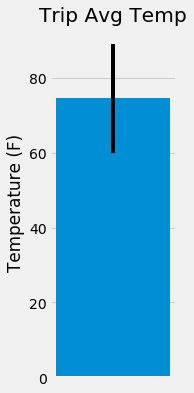

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

ptp = past_year_temps[0][2] - past_year_temps[0][0]
# Double-check that ptp should be the error bar and not std deviation

plt.figure(figsize=(2,6))
height = [past_year_temps[0][1]]
y_pos = np.arange(len(height))
plt.bar(y_pos, height, yerr=ptp/2)
plt.xticks([])
plt.ylabel("Temperature (F)")
plt.title("Trip Avg Temp")

## Daily Rainfall Average

1. Calculate the rainfall per weather station using the previous year's matching dates.

2. Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures. You are provided with a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic tobs that match that date string.

    a) Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.

    b) Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

    c) Use Pandas to plot an area plot (stacked=False) for the daily normals.

In [22]:
'''
Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
matching dates.

Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation.
'''

# Trip dates - 8/14/2017-8/23/2017

rain_data = pd.read_sql_query("SELECT sum(m.prcp) as total_rain, s.station, s.name, s.latitude, s.longitude, s.elevation \
                                 FROM measurement m \
                                 JOIN station s \
                                 ON m.station = s.station \
                                 WHERE m.date between '2016-08-14' and '2016-08-23' \
                                 GROUP BY s.station \
                                 ORDER BY total_rain DESC", engine)

rain_data

,total_rain,station,name,latitude,longitude,elevation
0,8.54,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,5.39,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,2.02,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,0.83,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,0.56,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,0.15,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
6,0.00,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [23]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Code adapted from https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python 

normals = []
dates = []

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + dt.timedelta(n)

start_date = dt.date(2017, 8, 14)
end_date = dt.date(2017, 8, 24)
for single_date in daterange(start_date, end_date):
    dates.append(single_date.strftime("%Y-%m-%d"))
    normals.append(daily_normals(single_date.strftime("%m-%d"))[0])

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `dates` range as the `date` index
df = pd.DataFrame(normals, columns =['tmin', 'tavg', 'tmax']) 
df['date'] = dates
df.set_index('date', inplace=True)

Text(0.5, 1.0, 'Daily temperature normals, August 14-23 2017')

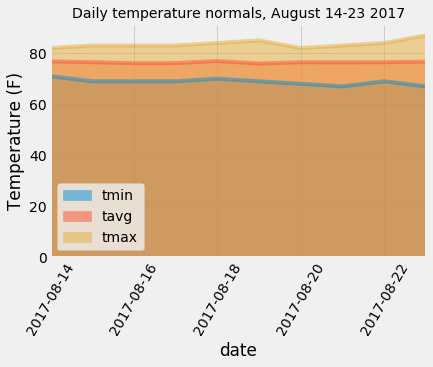

In [27]:
# Plot the daily normals as an area plot
df.plot.area(y=['tmin', 'tavg', 'tmax'], stacked=False)
plt.legend(loc='best')
plt.xticks(rotation=60)
plt.ylabel("Temperature (F)")
plt.title("Daily temperature normals, August 14-23 2017", fontsize=14)